In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from PIL import Image
import requests
from io import BytesIO

In [28]:
# Loading Image function
def process_image(image):
  image=np.array(image)
  image_shaped=tf.reshape(image,[1,image.shape[0],image.shape[1],image.shape[2]])
  image=tf.image.convert_image_dtype(image_shaped,tf.float32)
  return image

def load_image_url(image_url):
  response = requests.get(image_url)
  image=Image.open(BytesIO(response.content))
  image=process_image(image)
  return image

def load_image(image_url,image_size,dynamic_size=False,max_dynamic_size=512):
  img = load_image_url(image_url)
  img_raw = img
  if(tf.reduce_max(img)>1):
    img=img/255
  if(len(img.shape)==3):
    img=tf.stack([img,img,img],axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image,title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()





In [29]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"
image_size=384
labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
downloaded_file=tf.keras.utils.get_file("labels.txt", origin=labels_file)
classes = []
max_dynamic_size=512
dynamic_size=False
with open(downloaded_file) as f:
  labels = f.readlines()
  print(labels)
  classes = [l.strip() for l in labels]

['background\n', 'tench\n', 'goldfish\n', 'great white shark\n', 'tiger shark\n', 'hammerhead\n', 'electric ray\n', 'stingray\n', 'cock\n', 'hen\n', 'ostrich\n', 'brambling\n', 'goldfinch\n', 'house finch\n', 'junco\n', 'indigo bunting\n', 'robin\n', 'bulbul\n', 'jay\n', 'magpie\n', 'chickadee\n', 'water ouzel\n', 'kite\n', 'bald eagle\n', 'vulture\n', 'great grey owl\n', 'European fire salamander\n', 'common newt\n', 'eft\n', 'spotted salamander\n', 'axolotl\n', 'bullfrog\n', 'tree frog\n', 'tailed frog\n', 'loggerhead\n', 'leatherback turtle\n', 'mud turtle\n', 'terrapin\n', 'box turtle\n', 'banded gecko\n', 'common iguana\n', 'American chameleon\n', 'whiptail\n', 'agama\n', 'frilled lizard\n', 'alligator lizard\n', 'Gila monster\n', 'green lizard\n', 'African chameleon\n', 'Komodo dragon\n', 'African crocodile\n', 'American alligator\n', 'triceratops\n', 'thunder snake\n', 'ringneck snake\n', 'hognose snake\n', 'green snake\n', 'king snake\n', 'garter snake\n', 'water snake\n', 'vin

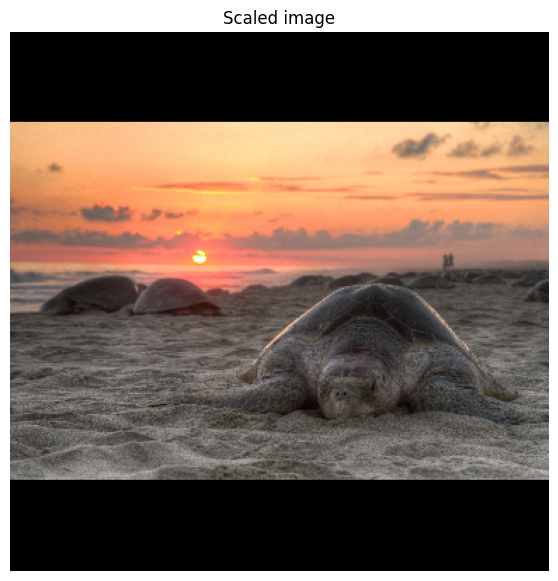

In [30]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg"
image, original_image = load_image(image_url, image_size, dynamic_size, max_dynamic_size=512)
show_image(image, 'Scaled image')

In [32]:
clf = hub.load(model_url)
input_shape=image.shape
warmup_input = tf.random.uniform(input_shape,0,1.0)
warmup = clf(warmup_input).numpy()

In [38]:
probabilities= tf.nn.softmax(clf(image).numpy())

CPU times: user 776 ms, sys: 12.3 ms, total: 788 ms
Wall time: 1.29 s
(1)   35 - leatherback turtle: 0.7747848629951477
(2)   34 - loggerhead: 0.10644030570983887
(3)   37 - terrapin: 0.0058746919967234135
(4)  148 - grey whale: 0.002594524761661887
(5)   36 - mud turtle: 0.0025598411448299885


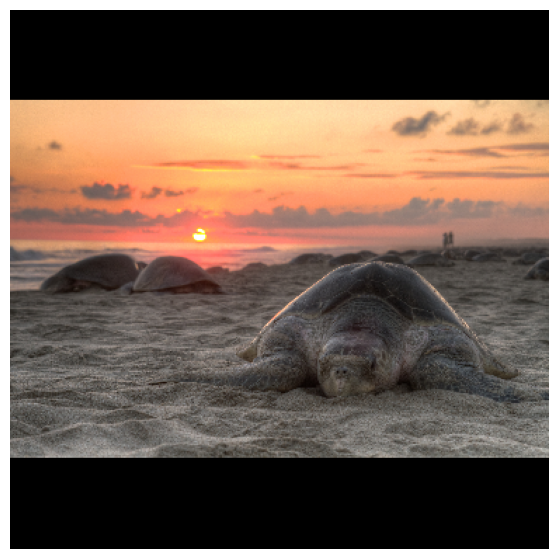

In [43]:
# Run model on image
%time probabilities = tf.nn.softmax(clf(image)).numpy()
top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)
show_image(image, '')